In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fetching the pre-trained model and initializing it

In [1]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
model=VGG19(
    include_top=False,
    weights='imagenet'
)
model.trainable=False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

Some helper functions to preprocess and to "deprocess" images

In [3]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def load_and_process_image(image_path):
  img=load_img(image_path)
  img=img_to_array(img)
  img=preprocess_input(img)
  img=np.expand_dims(img,axis=0)
  return img

In [9]:
def deprocess(x):
  #the numbers are defined according to the layers and model chosen
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68
  x=x[:,:,::-1]
  x=np.clip(x,0,255).astype('uint8')
  return x

In [10]:
def display_image(image):
  if len(image.shape)==4:
    img=np.squeeze(image,axis=0)
  img=deprocess(img)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return

In [20]:
content_path='/content/drive/My Drive/myprojects/content.jpg'
style_path='/content/drive/My Drive/myprojects/style.jpg'

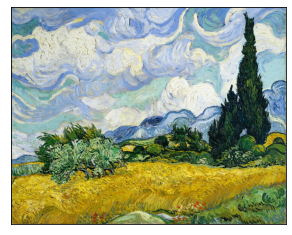

In [21]:
display_image(load_and_process_image(style_path))

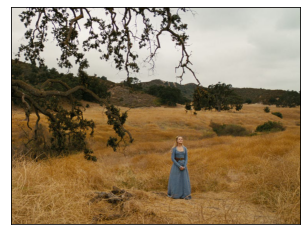

In [22]:
display_image(load_and_process_image(content_path))

Defining the content and style models by choosing appropriate layers

In [13]:
content_layer='block5_conv2'

style_layers=[
              'block1_conv1',
              'block3_conv1',
              'block5_conv1'
]

content_model=Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

style_models=[Model(inputs=model.input,
                    outputs=model.get_layer(layer).output) for layer in style_layers]

The content cost and gram matrix to calculate style cost

In [14]:
def content_cost(content,generated):
  aC=content_model(content)
  aG=content_model(generated)
  cost=tf.reduce_mean(tf.square(aC-aG))
  return cost

In [15]:
def gram_matrix(A):
  nC=int(A.shape[-1])
  a=tf.reshape(A,[-1,nC])
  n=tf.shape(a)[0]
  G=tf.matmul(a,a,transpose_a=True)
  return G/tf.cast(n,tf.float32)

In [16]:
lamb=1./len(style_models)

def style_cost(style,generated):
  J_style=0
  for style_model in style_models:
    aS=style_model(style)
    aG=style_model(generated)
    GS=gram_matrix(aS)
    GG=gram_matrix(aG)
    cost=tf.reduce_mean(tf.square(GS-GG))
    J_style+=cost*lamb
  return J_style

The training loop

In [34]:
import time
generated_images=[]
#alpha and beta decide the relative weight of the content and style images
def training_loop(content_path,style_path,iterations=20,
                  alpha=10.,beta=20.):
  content=load_and_process_image(content_path)
  style=load_and_process_image(style_path)
  generated=tf.Variable(content,dtype=tf.float32)
  optimizer=tf.keras.optimizers.Adam(learning_rate=7.)
  best_cost=1e12+0.1
  best_image=None
  start_time=time.time()
  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content=content_cost(content,generated)
      J_style=style_cost(style,generated)
      J_total=alpha*J_content+beta*J_style
    grads=tape.gradient(J_total,generated)  #calculate the gradients
    optimizer.apply_gradients([(grads,generated)])  #apply the gradients on the generated image
    if J_total<best_cost:
      best_cost=J_total
      best_image=generated.numpy()
    print('Cost at {}: {}. Time elapsed: {}'.format(i,J_total,time.time()-start_time))
    generated_images.append(generated.numpy())
  return best_image

In [37]:
best_image=training_loop(content_path,style_path,iterations=100)

Cost at 0: 2574984448.0. Time elapsed: 1.2675225734710693
Cost at 1: 830326528.0. Time elapsed: 2.4968812465667725
Cost at 2: 1135411712.0. Time elapsed: 3.7277109622955322
Cost at 3: 545070464.0. Time elapsed: 4.964794635772705
Cost at 4: 319837728.0. Time elapsed: 6.201366424560547
Cost at 5: 264526384.0. Time elapsed: 7.437420845031738
Cost at 6: 220531808.0. Time elapsed: 8.671276569366455
Cost at 7: 223253216.0. Time elapsed: 9.904658317565918
Cost at 8: 191150720.0. Time elapsed: 11.142538785934448
Cost at 9: 139132304.0. Time elapsed: 12.38102126121521
Cost at 10: 117693056.0. Time elapsed: 13.614882946014404
Cost at 11: 101355280.0. Time elapsed: 14.852629661560059
Cost at 12: 86316232.0. Time elapsed: 16.088627099990845
Cost at 13: 81004440.0. Time elapsed: 17.322579860687256
Cost at 14: 72923040.0. Time elapsed: 18.557480573654175
Cost at 15: 63552744.0. Time elapsed: 19.79235577583313
Cost at 16: 58746204.0. Time elapsed: 21.028695344924927
Cost at 17: 52060688.0. Time elaps

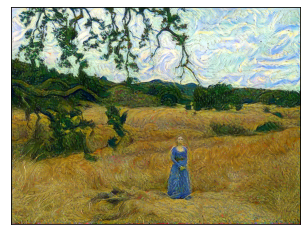

In [38]:
display_image(best_image)

In [39]:
#trying 500 iterations
best_image500=best_image=training_loop(content_path,style_path,iterations=500)

Cost at 0: 2574984448.0. Time elapsed: 1.2825582027435303
Cost at 1: 830326528.0. Time elapsed: 2.515899419784546
Cost at 2: 1135409280.0. Time elapsed: 3.748608350753784
Cost at 3: 545070720.0. Time elapsed: 4.987269878387451
Cost at 4: 319843072.0. Time elapsed: 6.2250096797943115
Cost at 5: 264528032.0. Time elapsed: 7.464227199554443
Cost at 6: 220528656.0. Time elapsed: 8.70244312286377
Cost at 7: 223244368.0. Time elapsed: 9.940744876861572
Cost at 8: 191156608.0. Time elapsed: 11.18367338180542
Cost at 9: 139139552.0. Time elapsed: 12.42850136756897
Cost at 10: 117693720.0. Time elapsed: 13.668402671813965
Cost at 11: 101357224.0. Time elapsed: 14.912006616592407
Cost at 12: 86316528.0. Time elapsed: 16.159666299819946
Cost at 13: 81006432.0. Time elapsed: 17.40462565422058
Cost at 14: 72919848.0. Time elapsed: 18.651941537857056
Cost at 15: 63547736.0. Time elapsed: 19.90371084213257
Cost at 16: 58747884.0. Time elapsed: 21.150802850723267
Cost at 17: 52065236.0. Time elapsed: 

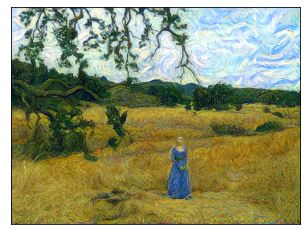

In [40]:
display_image(best_image500)

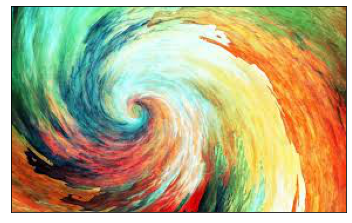

In [43]:
#trying another style
style_path='/content/drive/My Drive/myprojects/style2.jpg'
display_image(load_and_process_image(style_path))

Cost at 0: 6304719360.0. Time elapsed: 1.3587288856506348
Cost at 1: 3560225536.0. Time elapsed: 2.249990463256836
Cost at 2: 2432060928.0. Time elapsed: 3.143805980682373
Cost at 3: 2173768704.0. Time elapsed: 4.039343357086182
Cost at 4: 1591222144.0. Time elapsed: 4.935879468917847
Cost at 5: 1223794176.0. Time elapsed: 5.834097862243652
Cost at 6: 1003425280.0. Time elapsed: 6.731125831604004
Cost at 7: 818724288.0. Time elapsed: 7.632960319519043
Cost at 8: 688709248.0. Time elapsed: 8.5345299243927
Cost at 9: 641102016.0. Time elapsed: 9.436156272888184
Cost at 10: 592185408.0. Time elapsed: 10.337505578994751
Cost at 11: 509232448.0. Time elapsed: 11.243915796279907
Cost at 12: 443377312.0. Time elapsed: 12.149155616760254
Cost at 13: 400013920.0. Time elapsed: 13.054068326950073
Cost at 14: 362381888.0. Time elapsed: 13.96347951889038
Cost at 15: 329605024.0. Time elapsed: 14.877411365509033
Cost at 16: 305371168.0. Time elapsed: 15.78943419456482
Cost at 17: 283138688.0. Time 

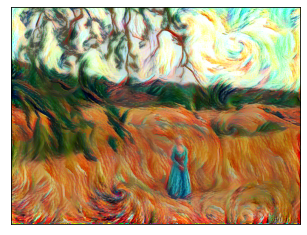

In [41]:
style_path='/content/drive/My Drive/myprojects/style2.jpg'
best_image2=best_image=training_loop(content_path,style_path,iterations=500)
display_image(best_image2)

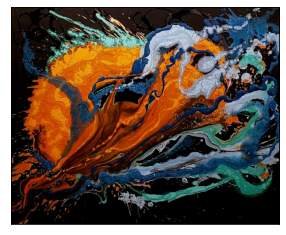

In [44]:
#another style again
style_path='/content/drive/My Drive/myprojects/style3.jpg'
display_image(load_and_process_image(style_path))

Cost at 0: 3628482816.0. Time elapsed: 3.944037914276123
Cost at 1: 1897956480.0. Time elapsed: 5.43799614906311
Cost at 2: 1363410048.0. Time elapsed: 6.939996719360352
Cost at 3: 1180944896.0. Time elapsed: 8.443399667739868
Cost at 4: 910990016.0. Time elapsed: 9.948840141296387
Cost at 5: 732027008.0. Time elapsed: 11.451661586761475
Cost at 6: 606611712.0. Time elapsed: 12.955747842788696
Cost at 7: 519916192.0. Time elapsed: 14.456717014312744
Cost at 8: 467338656.0. Time elapsed: 15.963890314102173
Cost at 9: 421344832.0. Time elapsed: 17.46622395515442
Cost at 10: 376892704.0. Time elapsed: 18.97111415863037
Cost at 11: 338589408.0. Time elapsed: 20.46946954727173
Cost at 12: 305467840.0. Time elapsed: 21.969754219055176
Cost at 13: 278595136.0. Time elapsed: 23.46734046936035
Cost at 14: 257017440.0. Time elapsed: 24.96916365623474
Cost at 15: 237881616.0. Time elapsed: 26.471383333206177
Cost at 16: 220578864.0. Time elapsed: 27.975620985031128
Cost at 17: 204337824.0. Time e

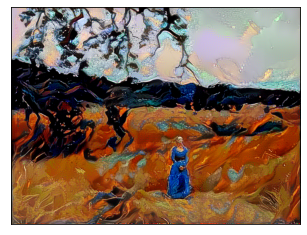

In [42]:
style_path='/content/drive/My Drive/myprojects/style3.jpg'
best_image3=best_image=training_loop(content_path,style_path,iterations=500)
display_image(best_image3)